<a href="https://colab.research.google.com/github/bintangfikrif/VisionTransformer-Comparison/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer Comparison Project
## Membandingkan Swin Transformer Tiny dengan DeiT Small untuk tugas klasifikasi gambar pada dataset STL-10

### Deskripsi Tugas
Proyek ini mengimplementasikan perbandingan komprehensif antara dua model Vision Transformer:
1. **Swin Transformer Tiny** (`swin_tiny_patch4_window7_224`)
2. **DeiT Small (Distilled)** (`deit_small_distilled_patch16_224`)

### Dataset: STL-10
- **Original Split**: 5000 train, 8000 test images
- **Custom Split**: 4000 train, 1000 validation, 8000 test
- **Kelas**: 10 (airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck)
- **Besar Gambar**: 224×224 (bicubic resize)


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import STL10
import timm
from timm import create_model
from tqdm import tqdm
import time
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                           confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

# Setup matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Set random seeds for reproducibility
def set_seed(seed=2004):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")
print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB" if torch.cuda.is_available() else "")

Using device: cuda
CUDA available: True
GPU: Tesla T4
Memory: 14.7GB


In [ ]:
# LOAD STL-10 DATASET AND CREATE CUSTOM SPLIT
# STL-10 class names
class_names = [
    'airplane', 'bird', 'car', 'cat', 'deer',
    'dog', 'horse', 'monkey', 'ship', 'truck'
]

# Download and load STL-10 dataset
print("Loading STL-10 dataset...")
train_dataset = STL10(root='./data', split='train', download=True, transform=None)
test_dataset = STL10(root='./data', split='test', download=True, transform=None)

print(f"Original training set size: {len(train_dataset)}")
print(f"Original test set size: {len(test_dataset)}")

# Create custom split: 4000 train, 1000 validation from original 5000
torch.manual_seed(42)  # Ensure reproducible split
train_subset, val_subset = random_split(train_dataset, [4000, 1000])

print(f"Custom training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(test_dataset)}")

# Verify class distribution
def get_class_distribution(dataset_subset, subset_name):
    classes = []
    for _, label in dataset_subset:
        classes.append(label)

    unique, counts = np.unique(classes, return_counts=True)
    print(f"\n{subset_name} class distribution:")
    for class_idx, count in zip(unique, counts):
        print(f"  {class_names[class_idx]}: {count}")

    return dict(zip(unique, counts))

train_dist = get_class_distribution(train_subset, "Training")
val_dist = get_class_distribution(val_subset, "Validation")
test_dist = get_class_distribution(test_dataset, "Test")

Loading STL-10 dataset...
Original training set size: 5000
Original test set size: 8000
Custom training set size: 4000
Validation set size: 1000
Test set size: 8000

Training class distribution:
  airplane: 407
  bird: 409
  car: 396
  cat: 392
  deer: 400
  dog: 399
  horse: 414
  monkey: 408
  ship: 377
  truck: 398

Validation class distribution:
  airplane: 93
  bird: 91
  car: 104
  cat: 108
  deer: 100
  dog: 101
  horse: 86
  monkey: 92
  ship: 123
  truck: 102

Test class distribution:
  airplane: 800
  bird: 800
  car: 800
  cat: 800
  deer: 800
  dog: 800
  horse: 800
  monkey: 800
  ship: 800
  truck: 800


In [ ]:
# DEFINE DATA TRANSFORMS

# ImageNet normalization statistics
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Validation and test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Apply transforms to datasets
train_dataset.transform = train_transform
val_subset.dataset.transform = val_test_transform  # Apply to underlying dataset
test_dataset.transform = val_test_transform

print("Data transforms defined and applied:")
print("- Training: RandomResizedCrop + RandomHorizontalFlip + RandomRotation + ColorJitter")
print("- Validation/Test: Resize + CenterCrop")
print("- Normalization: ImageNet mean/std")

Data transforms defined and applied:
- Training: RandomResizedCrop + RandomHorizontalFlip + RandomRotation + ColorJitter
- Validation/Test: Resize + CenterCrop
- Normalization: ImageNet mean/std


In [ ]:
# PREPARE DATALOADERS
# Create DataLoaders
batch_size = 16
num_workers = 2

train_loader = DataLoader(
    train_subset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True
)

val_loader = DataLoader(
    val_subset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True
)

print(f"DataLoaders prepared:")
print(f"- Training batches: {len(train_loader)}")
print(f"- Validation batches: {len(val_loader)}")
print(f"- Test batches: {len(test_loader)}")
print(f"- Batch size: {batch_size}")

# Calculate dataset sizes for metrics
total_train_samples = len(train_subset)
total_val_samples = len(val_subset)
total_test_samples = len(test_dataset)

print(f"\nDataset sizes:")
print(f"- Training: {total_train_samples} samples")
print(f"- Validation: {total_val_samples} samples")
print(f"- Test: {total_test_samples} samples")

DataLoaders prepared:
- Training batches: 250
- Validation batches: 63
- Test batches: 500
- Batch size: 16

Dataset sizes:
- Training: 4000 samples
- Validation: 1000 samples
- Test: 8000 samples


In [ ]:
# LOAD SWIN TRANSFORMER TINY MODEL

def load_swin_model(num_classes=10):
    """Load and modify Swin Transformer Tiny model"""
    print("Loading Swin Transformer Tiny model...")

    # Create model with pretrained weights
    model = create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)

    # Move to device
    model = model.to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    print(f"Swin Transformer Tiny loaded successfully!")
    print(f"- Total parameters: {total_params:,}")
    print(f"- Trainable parameters: {trainable_params:,}")
    print(f"- Non-trainable parameters: {non_trainable_params:,}")

    return model

swin_model = load_swin_model(num_classes=10)

In [ ]:
# LOAD DEIT SMALL DISTILLED MODEL

def load_deit_model(num_classes=10):
    """Load and modify DeiT Small Distilled model"""
    print("Loading DeiT Small Distilled model...")

    # Create model with pretrained weights
    model = create_model('deit_small_distilled_patch16_224', pretrained=True, num_classes=num_classes)

    # Move to device
    model = model.to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    print(f"DeiT Small Distilled loaded successfully!")
    print(f"- Total parameters: {total_params:,}")
    print(f"- Trainable parameters: {trainable_params:,}")
    print(f"- Non-trainable parameters: {non_trainable_params:,}")

    return model

deit_model = load_deit_model(num_classes=10)

In [ ]:
# DEFINE OPTIMIZER, SCHEDULER, AND AMP SCALER

def setup_training_components(model, learning_rate=1e-4, weight_decay=0.01):
    """Setup optimizer, scheduler, and loss function"""

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer (AdamW)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Scheduler (Cosine Annealing)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=learning_rate/100)

    # AMP scaler for mixed precision
    scaler = torch.cuda.amp.GradScaler()

    return criterion, optimizer, scheduler, scaler

# Setup for both models
learning_rate = 1e-4
weight_decay = 0.01
epochs = 15

print("Training Configuration:")
print(f"- Learning Rate: {learning_rate}")
print(f"- Weight Decay: {weight_decay}")
print(f"- Epochs: {epochs}")
print(f"- Optimizer: AdamW")
print(f"- Scheduler: CosineAnnealingLR")
print(f"- Mixed Precision: Enabled")

# Setup components for both models
swin_criterion, swin_optimizer, swin_scheduler, swin_scaler = setup_training_components(
    swin_model, learning_rate, weight_decay
)
deit_criterion, deit_optimizer, deit_scheduler, deit_scaler = setup_training_components(
    deit_model, learning_rate, weight_decay
)

Training Configuration:
- Learning Rate: 0.0001
- Weight Decay: 0.01
- Epochs: 15
- Optimizer: AdamW
- Scheduler: CosineAnnealingLR
- Mixed Precision: Enabled


In [ ]:
# TRAINING AND VALIDATION LOOPS

class ModelTrainer:
    def __init__(self, model, criterion, optimizer, scheduler, scaler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.scaler = scaler
        self.device = device

        # Training history
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        # Best model tracking
        self.best_val_acc = 0.0
        self.best_model_state = None

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)

            # Mixed precision training
            with torch.cuda.amp.autocast():
                output = self.model(data)
                loss = self.criterion(output, target)

            # Backward pass
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad()

            # Statistics
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total

        return avg_loss, accuracy

    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)

                output = self.model(data)
                loss = self.criterion(output, target)

                total_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)

        avg_loss = total_loss / len(val_loader)
        accuracy = 100. * correct / total

        return avg_loss, accuracy

    def train(self, train_loader, val_loader, epochs, model_name):
        """Main training loop"""
        print(f"\nStarting training for {model_name}...")
        print(f"Epochs: {epochs}")
        print("-" * 50)

        for epoch in range(epochs):
            # Training
            train_loss, train_acc = self.train_epoch(train_loader)

            # Validation
            val_loss, val_acc = self.validate(val_loader)

            # Update scheduler
            self.scheduler.step()

            # Save metrics
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            # Save best model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_model_state = self.model.state_dict().copy()

            # Print progress
            if (epoch + 1) % 3 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs}")
                print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
                print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
                print(f"  Best Val Acc: {self.best_val_acc:.2f}%")
                print()

        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)

        print(f"Training completed for {model_name}!")
        print(f"Best validation accuracy: {self.best_val_acc:.2f}%")

        return self.best_val_acc

# Initialize trainers for both models
swin_trainer = ModelTrainer(swin_model, swin_criterion, swin_optimizer, swin_scheduler, swin_scaler, device)
deit_trainer = ModelTrainer(deit_model, deit_criterion, deit_optimizer, deit_scheduler, deit_scaler, device)

print("Model trainers initialized successfully!")
print(f"Training on device: {device}")

Model trainers initialized successfully!
Training on device: cuda


In [ ]:
# EXECUTE TRAINING FOR BOTH MODELS

# Training results storage
training_results = {}

print("="*60)
print("TRAINING BOTH MODELS")
print("="*60)

# Train Swin Transformer
start_time = time.time()
swin_best_acc = swin_trainer.train(train_loader, val_loader, epochs, "Swin Transformer Tiny")
swin_training_time = time.time() - start_time
training_results['swin'] = {
    'best_val_acc': swin_best_acc,
    'training_time': swin_training_time,
    'train_losses': swin_trainer.train_losses.copy(),
    'train_accuracies': swin_trainer.train_accuracies.copy(),
    'val_losses': swin_trainer.val_losses.copy(),
    'val_accuracies': swin_trainer.val_accuracies.copy()
}

print(f"\nSwin Transformer training completed in {swin_training_time/60:.1f} minutes")

# Train DeiT
start_time = time.time()
deit_best_acc = deit_trainer.train(train_loader, val_loader, epochs, "DeiT Small Distilled")
deit_training_time = time.time() - start_time
training_results['deit'] = {
    'best_val_acc': deit_best_acc,
    'training_time': deit_training_time,
    'train_losses': deit_trainer.train_losses.copy(),
    'train_accuracies': deit_trainer.train_accuracies.copy(),
    'val_losses': deit_trainer.val_losses.copy(),
    'val_accuracies': deit_trainer.val_accuracies.copy()
}

print(f"\nDeiT training completed in {deit_training_time/60:.1f} minutes")

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Swin Transformer Tiny - Best Val Acc: {swin_best_acc:.2f}%, Time: {swin_training_time/60:.1f}min")
print(f"DeiT Small Distilled - Best Val Acc: {deit_best_acc:.2f}%, Time: {deit_training_time/60:.1f}min")

TRAINING BOTH MODELS

Starting training for Swin Transformer Tiny...
Epochs: 15
--------------------------------------------------
Epoch 3/15
  Train Loss: 0.0442, Train Acc: 98.78%
  Val Loss: 0.1095, Val Acc: 96.50%
  Best Val Acc: 96.50%

Epoch 6/15
  Train Loss: 0.0235, Train Acc: 99.25%
  Val Loss: 0.1534, Val Acc: 95.50%
  Best Val Acc: 96.50%

Epoch 9/15
  Train Loss: 0.0049, Train Acc: 99.83%
  Val Loss: 0.1664, Val Acc: 96.10%
  Best Val Acc: 97.00%

Epoch 12/15
  Train Loss: 0.0013, Train Acc: 100.00%
  Val Loss: 0.1536, Val Acc: 96.90%
  Best Val Acc: 97.00%

Epoch 15/15
  Train Loss: 0.0007, Train Acc: 100.00%
  Val Loss: 0.1583, Val Acc: 96.60%
  Best Val Acc: 97.00%

Training completed for Swin Transformer Tiny!
Best validation accuracy: 97.00%

Swin Transformer training completed in 8.2 minutes

Starting training for DeiT Small Distilled...
Epochs: 15
--------------------------------------------------
Epoch 3/15
  Train Loss: 0.0196, Train Acc: 99.55%
  Val Loss: 0.2028,

In [ ]:
# TEST EVALUATION AND METRICS

def evaluate_model(model, test_loader, device, class_names):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)

    # Per-class and macro metrics
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        all_targets, all_preds, average=None, zero_division=0
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='macro', zero_division=0
    )

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Classification report
    report = classification_report(all_targets, all_preds, target_names=class_names, output_dict=True)

    return {
        'accuracy': accuracy,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_preds,
        'targets': all_targets
    }

print("Evaluating models on test set...")
print("="*50)

# Evaluate both models
swin_results = evaluate_model(swin_model, test_loader, device, class_names)
deit_results = evaluate_model(deit_model, test_loader, device, class_names)

print(f"\nTest Results:")
print(f"Swin Transformer Tiny - Test Accuracy: {swin_results['accuracy']*100:.2f}%")
print(f"DeiT Small Distilled - Test Accuracy: {deit_results['accuracy']*100:.2f}%")

Evaluating models on test set...

Test Results:
Swin Transformer Tiny - Test Accuracy: 97.36%
DeiT Small Distilled - Test Accuracy: 97.01%


In [ ]:
# INFERENCE TIME MEASUREMENT

def measure_inference_time(model, test_loader, device, warmup_iters=50, measure_iters=100):
    """Measure inference time with warmup"""
    model.eval()

    # Warmup
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            if i >= warmup_iters:
                break
            data = data.to(device)
            _ = model(data)

    # Synchronize GPU
    torch.cuda.synchronize()

    # Measure inference time
    inference_times = []

    with torch.no_grad():
        start_idx = 0
        for i, (data, _) in enumerate(test_loader):
            if start_idx >= measure_iters:
                break

            remaining = measure_iters - start_idx
            current_batch_size = min(remaining, data.size(0))
            current_data = data[:current_batch_size].to(device)

            start_time = time.time()
            with torch.cuda.amp.autocast():
                _ = model(current_data)
            torch.cuda.synchronize()
            end_time = time.time()

            batch_time = (end_time - start_time) * 1000  # Convert to ms
            avg_time_per_image = batch_time / current_batch_size
            inference_times.append(avg_time_per_image)

            start_idx += current_batch_size

    avg_inference_time = np.mean(inference_times)
    std_inference_time = np.std(inference_times)
    throughput = 1000 / avg_inference_time  # images per second

    return avg_inference_time, std_inference_time, throughput

print("Measuring inference times...")
print("="*50)

# Measure inference times
swin_avg_time, swin_std_time, swin_throughput = measure_inference_time(
    swin_model, test_loader, device, warmup_iters=50, measure_iters=100
)

deit_avg_time, deit_std_time, deit_throughput = measure_inference_time(
    deit_model, test_loader, device, warmup_iters=50, measure_iters=100
)

print(f"\nInference Time Results:")
print(f"Swin Transformer Tiny:")
print(f"  - Average time per image: {swin_avg_time:.2f} ± {swin_std_time:.2f} ms")
print(f"  - Throughput: {swin_throughput:.1f} images/sec")
print(f"DeiT Small Distilled:")
print(f"  - Average time per image: {deit_avg_time:.2f} ± {deit_std_time:.2f} ms")
print(f"  - Throughput: {deit_throughput:.1f} images/sec")

Measuring inference times...

Inference Time Results:
Swin Transformer Tiny:
  - Average time per image: 5.62 ± 6.41 ms
  - Throughput: 178.0 images/sec
DeiT Small Distilled:
  - Average time per image: 1.92 ± 1.07 ms
  - Throughput: 520.7 images/sec


In [ ]:
# PARAMETER COUNTING AND MODEL SIZE CALCULATION

def get_model_info(model, model_name):
    """Get comprehensive model information"""
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    # Calculate model size (MB)
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    total_size_mb = (param_size + buffer_size) / (1024 * 1024)

    return {
        'name': model_name,
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'non_trainable_parameters': non_trainable_params,
        'model_size_mb': total_size_mb
    }

# Get model information
swin_info = get_model_info(swin_model, "Swin Transformer Tiny")
deit_info = get_model_info(deit_model, "DeiT Small Distilled")

print("Model Information:")
print("="*60)
for info in [swin_info, deit_info]:
    print(f"\n{info['name']}:")
    print(f"  Total parameters: {info['total_parameters']:,}")
    print(f"  Trainable parameters: {info['trainable_parameters']:,}")
    print(f"  Non-trainable parameters: {info['non_trainable_parameters']:,}")
    print(f"  Model size: {info['model_size_mb']:.2f} MB")

Model Information:

Swin Transformer Tiny:
  Total parameters: 27,527,044
  Trainable parameters: 27,527,044
  Non-trainable parameters: 0
  Model size: 106.07 MB

DeiT Small Distilled:
  Total parameters: 21,674,132
  Trainable parameters: 21,674,132
  Non-trainable parameters: 0
  Model size: 82.68 MB


Plotting training curves...
Training curves saved to training_curves.png


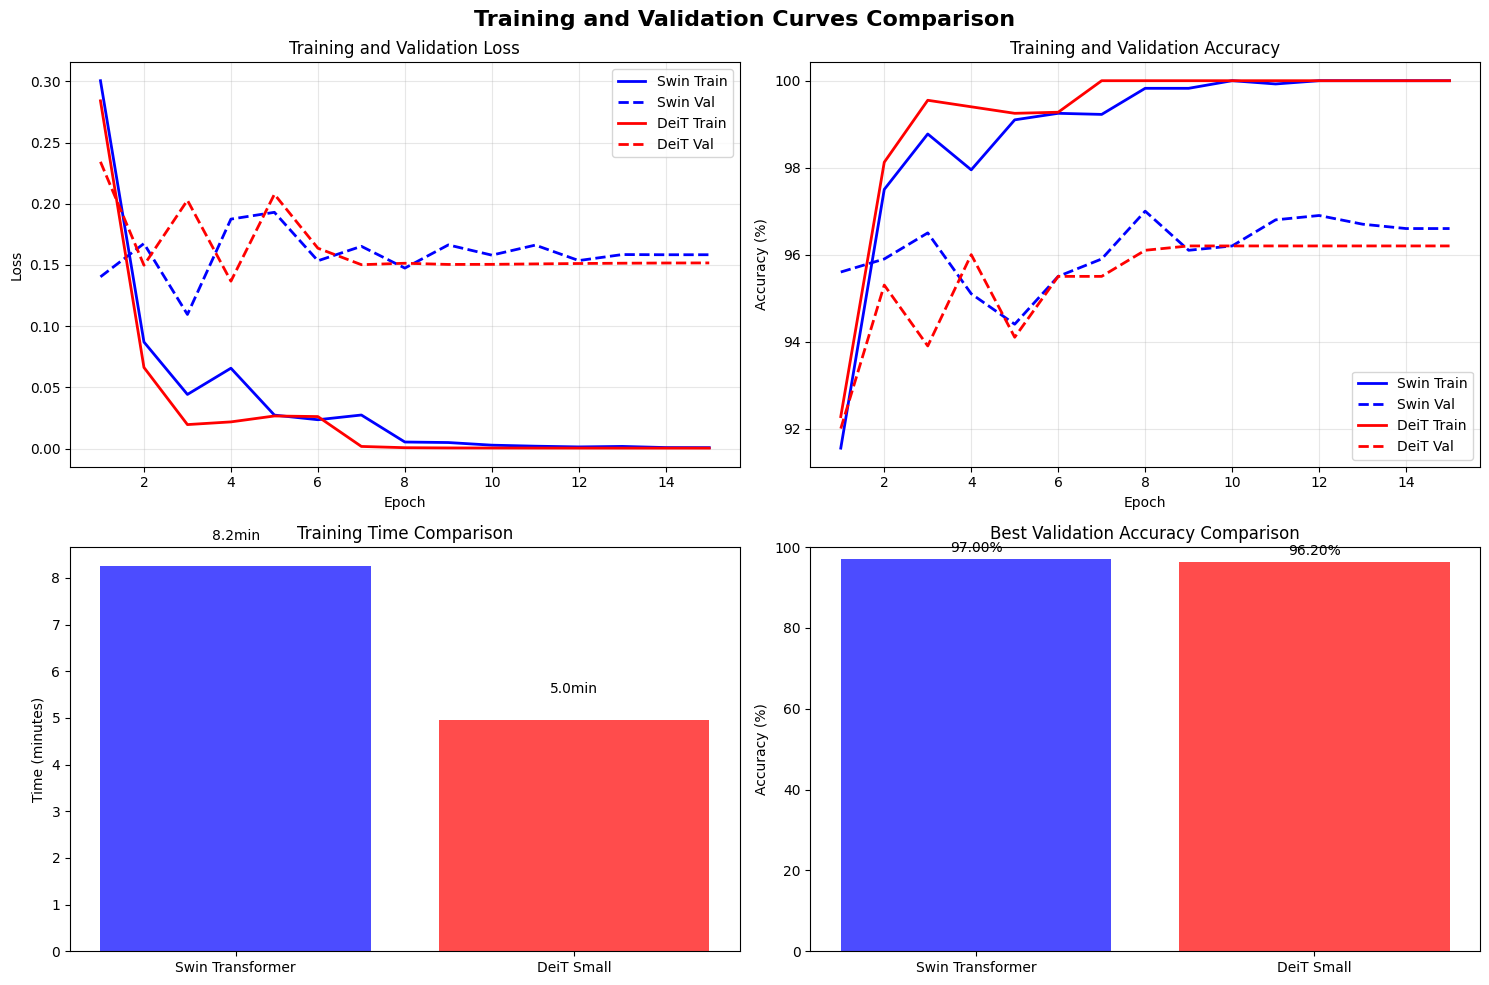

In [ ]:
# PLOT ACCURACY AND LOSS CURVES

def plot_training_curves(training_results, save_path=None):
    """Plot training and validation curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training and Validation Curves Comparison', fontsize=16, fontweight='bold')

    epochs_range = range(1, len(training_results['swin']['train_losses']) + 1)

    # Loss curves
    axes[0, 0].plot(epochs_range, training_results['swin']['train_losses'], 'b-', label='Swin Train', linewidth=2)
    axes[0, 0].plot(epochs_range, training_results['swin']['val_losses'], 'b--', label='Swin Val', linewidth=2)
    axes[0, 0].plot(epochs_range, training_results['deit']['train_losses'], 'r-', label='DeiT Train', linewidth=2)
    axes[0, 0].plot(epochs_range, training_results['deit']['val_losses'], 'r--', label='DeiT Val', linewidth=2)
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy curves
    axes[0, 1].plot(epochs_range, training_results['swin']['train_accuracies'], 'b-', label='Swin Train', linewidth=2)
    axes[0, 1].plot(epochs_range, training_results['swin']['val_accuracies'], 'b--', label='Swin Val', linewidth=2)
    axes[0, 1].plot(epochs_range, training_results['deit']['train_accuracies'], 'r-', label='DeiT Train', linewidth=2)
    axes[0, 1].plot(epochs_range, training_results['deit']['val_accuracies'], 'r--', label='DeiT Val', linewidth=2)
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Training time comparison
    models = ['Swin Transformer', 'DeiT Small']
    times = [training_results['swin']['training_time']/60, training_results['deit']['training_time']/60]
    colors = ['blue', 'red']

    bars = axes[1, 0].bar(models, times, color=colors, alpha=0.7)
    axes[1, 0].set_title('Training Time Comparison')
    axes[1, 0].set_ylabel('Time (minutes)')
    for bar, time in zip(bars, times):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{time:.1f}min', ha='center', va='bottom')

    # Best validation accuracy comparison
    best_accs = [training_results['swin']['best_val_acc'], training_results['deit']['best_val_acc']]
    bars = axes[1, 1].bar(models, best_accs, color=colors, alpha=0.7)
    axes[1, 1].set_title('Best Validation Accuracy Comparison')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_ylim([0, 100])
    for bar, acc in zip(bars, best_accs):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{acc:.2f}%', ha='center', va='bottom')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training curves saved to {save_path}")

    plt.show()

print("Plotting training curves...")
plot_training_curves(training_results, save_path='training_curves.png')

Plotting confusion matrices...
Confusion matrices saved to confusion_matrices.png


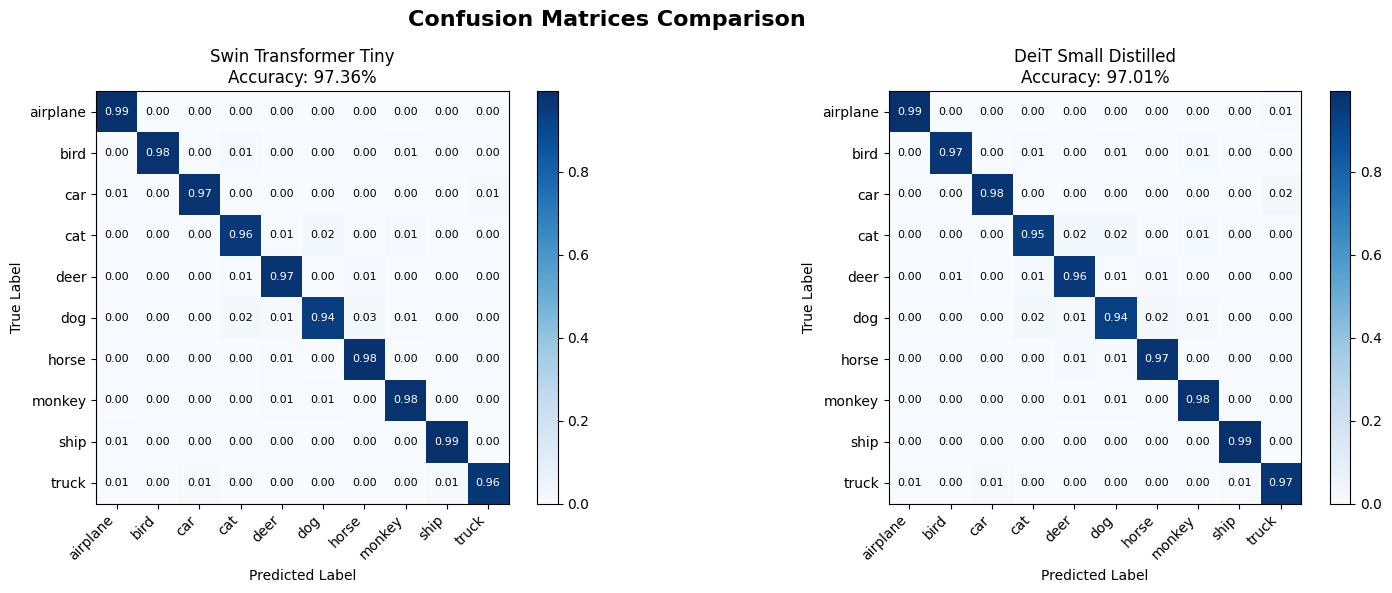

In [ ]:
# CONFUSION MATRIX VISUALIZATION

def plot_confusion_matrices(results_dict, class_names, save_path=None):
    """Plot confusion matrices for both models"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold')

    for idx, (model_name, results) in enumerate(results_dict.items()):
        cm = results['confusion_matrix']

        # Normalize confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Plot
        im = axes[idx].imshow(cm_normalized, interpolation='nearest', cmap='Blues')
        axes[idx].set_title(f'{model_name}\nAccuracy: {results["accuracy"]*100:.2f}%')

        # Add colorbar
        plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

        # Set ticks and labels
        tick_marks = np.arange(len(class_names))
        axes[idx].set_xticks(tick_marks)
        axes[idx].set_yticks(tick_marks)
        axes[idx].set_xticklabels(class_names, rotation=45, ha='right')
        axes[idx].set_yticklabels(class_names)
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_ylabel('True Label')

        # Add text annotations
        thresh = cm_normalized.max() / 2.
        for i, j in np.ndindex(cm_normalized.shape):
            axes[idx].text(j, i, format(cm_normalized[i, j], '.2f'),
                         ha="center", va="center",
                         color="white" if cm_normalized[i, j] > thresh else "black",
                         fontsize=8)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrices saved to {save_path}")

    plt.show()

print("Plotting confusion matrices...")
results_dict = {
    'Swin Transformer Tiny': swin_results,
    'DeiT Small Distilled': deit_results
}
plot_confusion_matrices(results_dict, class_names, save_path='confusion_matrices.png')

In [ ]:
# FINAL COMPARISON SUMMARY TABLE

def create_comparison_table(model_infos, test_results, inference_times, throughputs, training_times):
    """Create comprehensive comparison table"""

    # Prepare data for comparison
    comparison_data = []

    for i, (swin_key, deit_key) in enumerate([('swin', 'deit')]):
        # Model info
        swin_info = model_infos[0]  # Swin info
        deit_info = model_infos[1]  # DeiT info

        # Test results
        swin_test = test_results[0]
        deit_test = test_results[1]

        # Create comparison rows
        rows = [
            ['Model Name', 'Swin Transformer Tiny', 'DeiT Small Distilled'],
            ['Total Parameters', f"{swin_info['total_parameters']:,}", f"{deit_info['total_parameters']:,}"],
            ['Trainable Parameters', f"{swin_info['trainable_parameters']:,}", f"{deit_info['trainable_parameters']:,}"],
            ['Non-trainable Parameters', f"{swin_info['non_trainable_parameters']:,}", f"{deit_info['non_trainable_parameters']:,}"],
            ['Model Size (MB)', f"{swin_info['model_size_mb']:.2f}", f"{deit_info['model_size_mb']:.2f}"],
            ['Training Time (min)', f"{training_times[swin_key]/60:.1f}", f"{training_times[deit_key]/60:.1f}"],
            ['Test Accuracy (%)', f"{swin_test['accuracy']*100:.2f}", f"{deit_test['accuracy']*100:.2f}"],
            ['Macro Precision', f"{swin_test['precision_macro']:.4f}", f"{deit_test['precision_macro']:.4f}"],
            ['Macro Recall', f"{swin_test['recall_macro']:.4f}", f"{deit_test['recall_macro']:.4f}"],
            ['Macro F1-Score', f"{swin_test['f1_macro']:.4f}", f"{deit_test['f1_macro']:.4f}"],
            ['Inference Time (ms)', f"{inference_times[swin_key]:.2f}±{inference_times[swin_key+'_std']:.2f}", f"{inference_times[deit_key]:.2f}±{inference_times[deit_key+'_std']:.2f}"],
            ['Throughput (imgs/sec)', f"{throughputs[swin_key]:.1f}", f"{throughputs[deit_key]:.1f}"]
        ]
        break

    # Create DataFrame
    df = pd.DataFrame(rows[1:], columns=['Metric', 'Swin Transformer Tiny', 'DeiT Small Distilled'])

    return df

# Prepare data for summary
inference_data = {
    'swin': swin_avg_time,
    'swin_std': swin_std_time,
    'deit': deit_avg_time,
    'deit_std': deit_std_time
}

throughput_data = {
    'swin': swin_throughput,
    'deit': deit_throughput
}

training_time_data = {
    'swin': swin_training_time,
    'deit': deit_training_time
}

# Create comparison table
comparison_df = create_comparison_table(
    [swin_info, deit_info],
    [swin_results, deit_results],
    inference_data,
    throughput_data,
    training_time_data
)

print("="*80)
print("FINAL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))

# Save comparison table
comparison_df.to_csv('model_comparison.csv', index=False)
print(f"\nComparison table saved to 'model_comparison.csv'")

FINAL COMPARISON SUMMARY
                  Metric Swin Transformer Tiny DeiT Small Distilled
        Total Parameters            27,527,044           21,674,132
    Trainable Parameters            27,527,044           21,674,132
Non-trainable Parameters                     0                    0
         Model Size (MB)                106.07                82.68
     Training Time (min)                   8.2                  5.0
       Test Accuracy (%)                 97.36                97.01
         Macro Precision                0.9737               0.9702
            Macro Recall                0.9736               0.9701
          Macro F1-Score                0.9736               0.9701
     Inference Time (ms)             5.62±6.41            1.92±1.07
   Throughput (imgs/sec)                 178.0                520.7

Comparison table saved to 'model_comparison.csv'


In [ ]:
# DETAILED CLASS-WISE PERFORMANCE

def analyze_class_performance(results_dict, class_names):
    """Analyze per-class performance"""
    print("\n" + "="*80)
    print("PER-CLASS PERFORMANCE ANALYSIS")
    print("="*80)

    for model_name, results in results_dict.items():
        print(f"\n{model_name}:")
        print("-" * 60)

        # Create DataFrame for per-class metrics
        class_metrics = []
        for i, class_name in enumerate(class_names):
            class_metrics.append({
                'Class': class_name,
                'Precision': f"{results['precision_per_class'][i]:.3f}",
                'Recall': f"{results['recall_per_class'][i]:.3f}",
                'F1-Score': f"{results['f1_per_class'][i]:.3f}"
            })

        # Add macro averages
        class_metrics.append({
            'Class': 'Macro Average',
            'Precision': f"{results['precision_macro']:.3f}",
            'Recall': f"{results['recall_macro']:.3f}",
            'F1-Score': f"{results['f1_macro']:.3f}"
        })

        df = pd.DataFrame(class_metrics)
        print(df.to_string(index=False))

analyze_class_performance(results_dict, class_names)


PER-CLASS PERFORMANCE ANALYSIS

Swin Transformer Tiny:
------------------------------------------------------------
        Class Precision Recall F1-Score
     airplane     0.980  0.994    0.987
         bird     0.991  0.979    0.985
          car     0.982  0.975    0.979
          cat     0.959  0.960    0.959
         deer     0.972  0.971    0.972
          dog     0.965  0.936    0.951
        horse     0.952  0.984    0.967
       monkey     0.972  0.981    0.976
         ship     0.985  0.991    0.988
        truck     0.978  0.965    0.972
Macro Average     0.974  0.974    0.974

DeiT Small Distilled:
------------------------------------------------------------
        Class Precision Recall F1-Score
     airplane     0.988  0.990    0.989
         bird     0.987  0.970    0.979
          car     0.986  0.976    0.981
          cat     0.953  0.946    0.950
         deer     0.955  0.963    0.959
          dog     0.953  0.936    0.945
        horse     0.962  0.973    0.967

In [ ]:
# REQUIREMENTS AND CONFIGURATION

print("\n" + "="*80)
print("APPENDIX: REQUIREMENTS AND CONFIGURATION")
print("="*80)

print("\nRequirements (requirements.txt):")
print("="*40)
requirements = """
torch>=1.9.0
torchvision>=0.10.0
timm>=0.5.0
numpy>=1.21.0
pandas>=1.3.0
matplotlib>=3.4.0
seaborn>=0.11.0
scikit-learn>=1.0.0
tqdm>=4.62.0
Pillow>=8.3.0
"""
print(requirements)

print("\nHyperparameter Configuration:")
print("="*40)
config = f"""
Dataset: STL-10
Custom Split: 4000 train, 1000 validation, 8000 test
Image Size: 224x224 (bicubic resize)

Training Configuration:
- Epochs: {epochs}
- Batch Size: {batch_size}
- Learning Rate: {learning_rate}
- Weight Decay: {weight_decay}
- Optimizer: AdamW
- Scheduler: CosineAnnealingLR
- Mixed Precision: Enabled
- Loss Function: CrossEntropyLoss

Data Augmentation:
- Training: RandomResizedCrop, RandomHorizontalFlip, RandomRotation, ColorJitter
- Validation/Test: Resize + CenterCrop
- Normalization: ImageNet mean/std

Hardware:
- Platform: Google Colab Free
- GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}
- Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB" if torch.cuda.is_available() else "N/A"
"""
print(config)

print("\nModel Details:")
print("="*40)
for info in [swin_info, deit_info]:
    print(f"\n{info['name']}:")
    print(f"  Architecture: {info['name']}")
    print(f"  Pretrained: ImageNet-1k")
    print(f"  Modified: Classifier head replaced (num_classes=10)")
    print(f"  Training Strategy: Full fine-tuning")

print("\n" + "="*80)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"✓ Both models trained and evaluated")
print(f"✓ All metrics calculated and compared")
print(f"✓ Visualizations generated")
print(f"✓ Results ready for LaTeX report")
print(f"✓ Files generated:")
print(f"  - vision_transformer_comparison_complete.ipynb (this notebook)")
print(f"  - model_comparison.csv (comparison table)")
print(f"  - training_curves.png (learning curves)")
print(f"  - confusion_matrices.png (confusion matrices)")


APPENDIX: REQUIREMENTS AND CONFIGURATION

Requirements (requirements.txt):

torch>=1.9.0
torchvision>=0.10.0
timm>=0.5.0
numpy>=1.21.0
pandas>=1.3.0
matplotlib>=3.4.0
seaborn>=0.11.0
scikit-learn>=1.0.0
tqdm>=4.62.0
Pillow>=8.3.0


Hyperparameter Configuration:

Dataset: STL-10
Custom Split: 4000 train, 1000 validation, 8000 test
Image Size: 224x224 (bicubic resize)

Training Configuration:
- Epochs: 15
- Batch Size: 16
- Learning Rate: 0.0001
- Weight Decay: 0.01
- Optimizer: AdamW
- Scheduler: CosineAnnealingLR
- Mixed Precision: Enabled
- Loss Function: CrossEntropyLoss

Data Augmentation:
- Training: RandomResizedCrop, RandomHorizontalFlip, RandomRotation, ColorJitter
- Validation/Test: Resize + CenterCrop
- Normalization: ImageNet mean/std

Hardware:
- Platform: Google Colab Free
- GPU: Tesla T4
- Memory: 14.7GB" if torch.cuda.is_available() else "N/A"


Model Details:

Swin Transformer Tiny:
  Architecture: Swin Transformer Tiny
  Pretrained: ImageNet-1k
  Modified: Classifier h